***
# <font color=red>Building and Explaining a Text Classifier using AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Text Classification.

Copyright © 2025, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook

In this notebook we will build a classifier using the Oracle AutoMLx tool for the public 20newsgroup dataset. The dataset is a binary classification dataset, and more details about the dataset can be found at http://qwone.com/~jason/20Newsgroups/.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to exercise control over the AutoML training process. We then evaluate the different models trained by AutoML. Finally we provide an overview of the possibilities that Oracle AutoMLx offers for explaining the predictions of the tuned model.

---
## Prerequisites

  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience
---

## Business Use

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks differs according to type of problem to be solved, eg. Text classification primarily involve the following steps:
- Preprocess dataset (vectorize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'>Setup</a>
- <a href='#load-data'>Load the 20newsgroup Income dataset</a>
- <a href='#AutoML'>AutoML</a>
  - <a href='#Engine'>Set the engine</a>
  - <a href='#provider'>Create an Instance of Oracle AutoMLx</a>
  - <a href='#default'>Train a Model using AutoMLx</a>
  - <a href='#analyze'>Analyze the AutoMLX optimization process </a>
      - <a href='#algorithm-selection'>Algorithm Selection</a>
      - <a href='#adaptive-sampling'>Adaptive Sampling</a>
      - <a href='#feature-selection'>Feature Selection</a>
      - <a href='#hyperparameter-tuning'>Hyperparameter Tuning</a>
  - <a href='#advanced'>Advanced AutoML Configuration</a>
- <a href='#MLX'>Machine Learning Explainability (MLX)</a>
  - <a href='#MLX-initialization'>Initialize an MLExplainer</a>
  - <a href='#MLX-global'>Global Token Importance</a>
  - <a href='#MLX-local'>Local Token Importance</a>
- <a href='#ref'>References</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
import time
import datetime

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15

import automlx
from automlx import init

<a id='load-data'></a>
## Load the 20 News Group dataset
We start by reading in the dataset from sklearn. The dataset has already been pre-split into training and test sets. The training set will be used to create a Machine Learning model using AutoMLx, and the test set will be used to evaluate the model's performance on unseen data.

In [3]:
train = fetch_20newsgroups(subset='train')
test = fetch_20newsgroups(subset='test')

target_names = train.target_names

X_train, y_train = pd.DataFrame(train.data), pd.DataFrame(train.target)
X_test, y_test = pd.DataFrame(test.data), pd.DataFrame(test.target)

column_names = ["Message"]
X_train.columns = column_names
X_test.columns = column_names

Lets look at a few of the values in the data. 20 NewsGroup is a classification dataset made of text samples. Each sample has an associated class (also called topic), which can be one of the followings:

In [4]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We display some examples of data samples.

In [5]:
X_train.head()

Message
0  From: lerxst@wam.umd.edu (where's my thing)\nS...
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...

In [6]:
len(X_train)

11314

We further downsample the train set to have a reasonable training time for this demonstration.

In [7]:
X_train, _, y_train, _ = train_test_split(X_train, y_train,
                                          test_size=0.7,
                                          stratify=y_train,
                                          random_state=42)

Finally we generate a validation set and only use that for internal pipeline validation.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      stratify=y_train,
                                                      random_state=42)

<a id='AutoML'></a>
## AutoML

<a id='Engine'></a>
### Setting the execution engine
The AutoML package offers the function `init`, which allows to initialize the parallelization engine.

In [9]:
init(engine='ray')

[2024-05-23 09:56:52,788] [automlx.backend] Overwriting ray session directory to /tmp/zdvafa74/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


<a id='provider'></a>
### Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular it allows to find a tuned model for any supervised prediction task, for example: classification or regression where the target can be binary, categorical or real-valued.

AutoML consists of five main steps:
- **Preprocessing** (Feature extraction and selection) : The pipeline extracts tabular features using [TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) that it then selects between.
- **Algorithm Selection** : Identify the right classification algorithm for a given dataset, choosing from amongst:
   - AdaBoostClassifier
   - CatBoostClassifier
   - DecisionTreeClassifier
   - ExtraTreesClassifier
   - TorchMLPClassifier
   - KNeighborsClassifier
   - LGBMClassifier
   - LinearSVC
   - LogisticRegression
   - RandomForestClassifier
   - SVC
   - XGBClassifier
   - GaussianNB
   - TabNetClassifier
- **Adaptive Sampling** : Select a subset of the data samples for the model to be trained on.
- **Feature Selection** : Select a subset of the features (extracted with TFIDF), based on the previously selected model. In the rest of this notebook, we will implicitly refer to the extracted features as data features.
- **Hyperparameter Tuning** : Find the right model parameters that maximize score for the given dataset.

All these pieces are readily combined into a simple AutoMLx pipeline which automates the entire Machine Learning process with minimal user input/interaction.

<a id='default'></a>
### Train a model using AutoMLx

The AutoMLx API is quite simple to work with. We create an instance of the pipeline. Next, the training data is passed to the `fit()` function which executes the four previously mentioned steps.

A model is then generated and can be used for prediction tasks. We use the roc_auc scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [10]:
est1 = automlx.Pipeline(task='classification')
est1.fit(X_train, y_train, X_valid, y_valid, col_types=['text'])

y_predict = est1.predict(X_test)
score_default = f1_score(y_test, y_predict, average="micro")

print('F1 Micro Score on test data: {:3.3f}'.format(score_default))

[2024-05-23 09:56:57,946] [automlx.interface] Dataset shape: (3394,1)
[2024-05-23 09:57:01,123] [sanerec.autotuning.parameter] Hyperparameter epsilon autotune range is set to its validation range. This could lead to long training times
[2024-05-23 09:57:01,147] [sanerec.autotuning.parameter] Hyperparameter repeat_quality_threshold autotune range is set to its validation range. This could lead to long training times
[2024-05-23 09:57:01,154] [sanerec.autotuning.parameter] Hyperparameter scope autotune range is set to its validation range. This could lead to long training times
[2024-05-23 09:57:01,487] [automlx.data_transform] Running preprocessing. Number of features: 2
[2024-05-23 09:57:16,738] [automlx.data_transform] Preprocessing completed. Took 15.251 secs
[2024-05-23 09:57:50,052] [automlx.process] Running Model Generation
[2024-05-23 09:57:50,345] [automlx.process] CatBoostClassifier is disabled. The CatBoostClassifier model is only recommended for datasets with less than 10000 

<a id='analyze'></a>
### Analyze the AutoMLx optimization process

During the AutoML process, a summary of the optimization process is logged. It consists of:
- Information about the training data
- Information about the AutoMLx Pipeline, such as:
    - selected features that AutoMLx found to be most predictive in the training data;
    - selected algorithm that was the best choice for this data;
    - hyperparameters for the selected algorithm.

AutoMLx provides a print_summary API to output all the different trials performed.

In [11]:
est1.print_summary()

Training Dataset size                                                                                                                                                                                                (2715, 1)
Validation Dataset size                                                                                                                                                                                               (679, 1)
CV                                                                                                                                                                                          ManualSplit(Shuffle=False, Seed=7)
Optimization Metric                                                                                                                                                                                               neg_log_loss
Selected Algorithm                                                                                                                                                                                              LGBMClassifier
Selected Hyperparameters  {'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.00119999, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}
AutoMLx version                                                                                                                                                                                                         24.2.0
Python version                                                                                                                          3.8.7 (default, Aug 25 2022, 13:59:56) \n[GCC 8.5.0 20210514 (Red Hat 8.5.0-10.1.0.1)]

Step # Samples  # Features                Algorithm  \
0      Model Selection      2715       25238          LGBMClassifier    
1      Model Selection      2715       25238      TorchMLPClassifier    
2      Model Selection      2715       25238              GaussianNB    
3      Model Selection      2715       25238  DecisionTreeClassifier    
4    Feature Selection      2715       14235          LGBMClassifier    
5    Feature Selection      2715        9885          LGBMClassifier    
6    Feature Selection      2715       11862          LGBMClassifier    
7    Feature Selection      2715       20499          LGBMClassifier    
8    Feature Selection      2715       14235          LGBMClassifier    
9    Feature Selection      2715       17082          LGBMClassifier    
10   Feature Selection      2715        5720          LGBMClassifier    
11   Feature Selection      2715        2800          LGBMClassifier    
12   Feature Selection      2715       24599          LGBMClassifier    
13   Feature Selection      2715       11862          LGBMClassifier    
14   Feature Selection      2715       20499          LGBMClassifier    
15   Feature Selection      2715       17082          LGBMClassifier    
16   Feature Selection      2715       24599          LGBMClassifier    
17   Feature Selection      2715        2757          LGBMClassifier    
18   Feature Selection      2715        8237          LGBMClassifier    
19   Feature Selection      2715        6864          LGBMClassifier    
20   Feature Selection      2715        4766          LGBMClassifier    
21   Feature Selection      2715        9885          LGBMClassifier    
22   Feature Selection      2715        8237          LGBMClassifier    
23   Feature Selection      2715        3309          LGBMClassifier    
24   Feature Selection      2715        6864          LGBMClassifier    
25   Feature Selection      2715        1914          LGBMClassifier    
26   Feature Selection      2715        5720          LGBMClassifier    
27   Feature Selection      2715        1595          LGBMClassifier    
28   Feature Selection      2715        2297          LGBMClassifier    
29   Feature Selection      2715        4766          LGBMClassifier    
30   Feature Selection      2715        3309          LGBMClassifier    
31   Feature Selection      2715        2757          LGBMClassifier    
32   Feature Selection      2715        1329          LGBMClassifier    
33   Feature Selection      2715        3971          LGBMClassifier    
34   Feature Selection      2715        3971          LGBMClassifier    
35   Feature Selection      2715        2757          LGBMClassifier    
36   Feature Selection      2715        1329          LGBMClassifier    
37   Feature Selection      2715        1595          LGBMClassifier    
38   Feature Selection      2715        1914          LGBMClassifier    
39   Feature Selection      2715       11862          LGBMClassifier    
40   Feature Selection      2715        2297          LGBMClassifier    
41   Feature Selection      2715        2297          LGBMClassifier    
42   Feature Selection      2715       13407          LGBMClassifier    
43   Feature Selection      2715        1107          LGBMClassifier    
44   Feature Selection      2715        1107          LGBMClassifier    
45   Feature Selection      2715         922          LGBMClassifier    
46   Feature Selection      2715         922          LGBMClassifier    
47   Feature Selection      2715        1914          LGBMClassifier    
48   Feature Selection      2715         640          LGBMClassifier    
49   Feature Selection      2715         768          LGBMClassifier    
50   Feature Selection      2715        9885          LGBMClassifier    
51   Feature Selection      2715         768          LGBMClassifier    
52   Feature Selection      2715        1595          LGBMClassifier    
53   Feature Selection      2715        1329          LGBMClassifier    
54 

We also provide the capability to visualize the results of each stage of the AutoMLx pipeline.

<a id='algorithm-selection'></a>
#### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal.

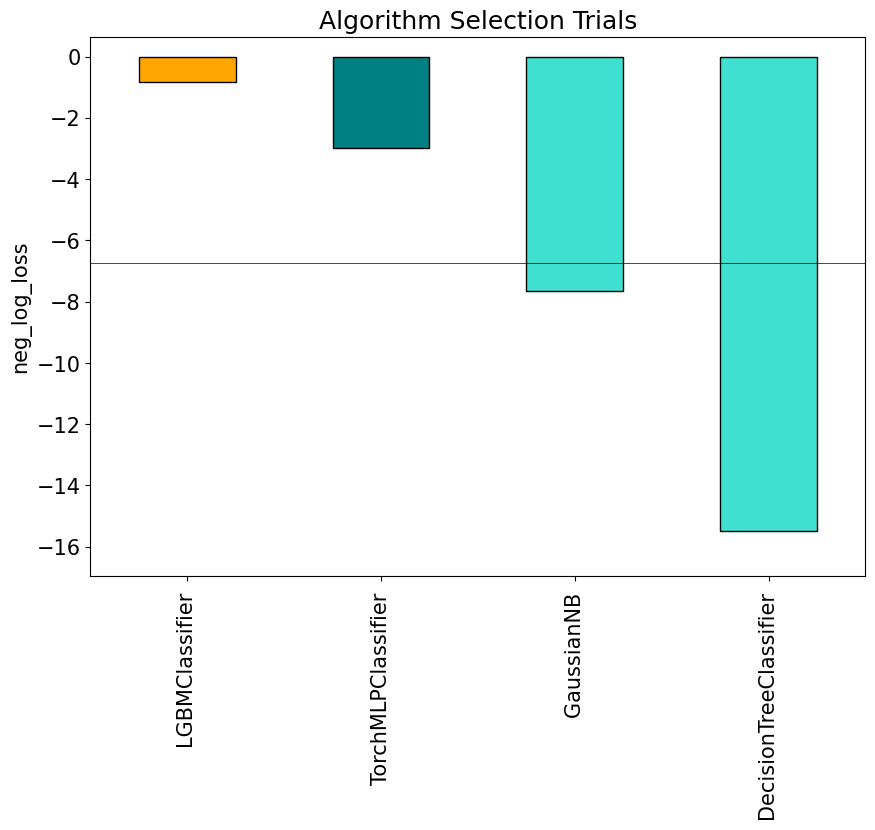

In [12]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Selection')]
name_of_score_column = f"Score ({est1._inferred_score_metric[0].name})"
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
scores = trials[name_of_score_column].tolist()
models = trials['Algorithm'].tolist()
colors = []

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)
s = s.dropna()
for f in s.keys():
    if f.strip()  ==  est1.selected_model_.strip():
        colors.append('orange')
    elif s[f] >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')

fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel(est1._inferred_score_metric[0].name)
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()

<a id='feature-selection'></a>
#### Feature Selection
After finding a sample subset, the next step is to find a relevant feature subset to maximize score for the chosen algorithm. The feature selection step identifies the smallest feature subset that does not compromise on the score of the chosen algorithm. The orange line shows the optimal number of features chosen by Feature Selection.

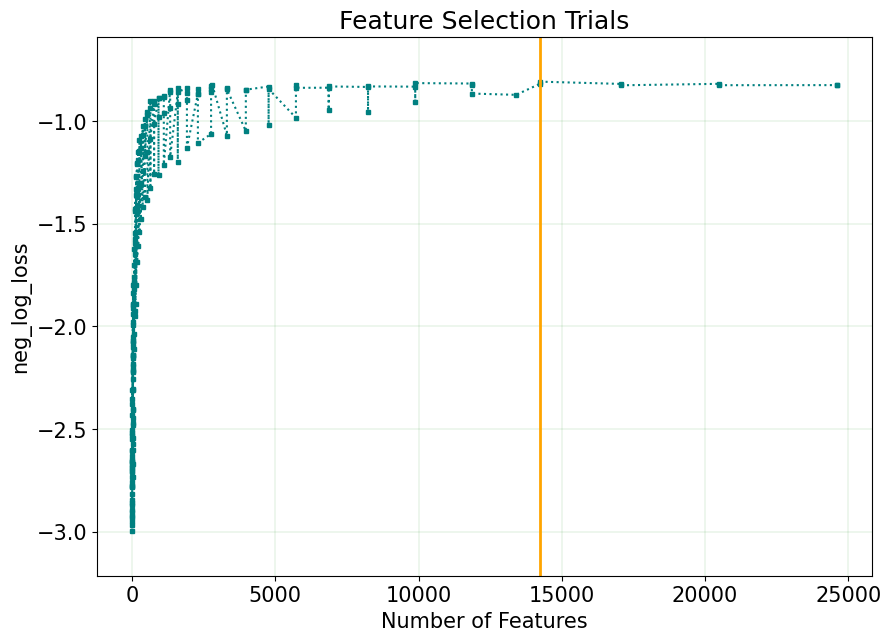

In [13]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Feature Selection')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.sort_values(by=['# Features'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
n_features = trials['# Features'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
fig, ax = plt.subplots(1)
ax.set_title("Feature Selection Trials")
ax.set_xlabel("Number of Features")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.plot(n_features, scores, 'k:', marker="s", color='teal', markersize=3)
ax.axvline(x=len(est1.selected_features_names_), color='orange', linewidth=2.0)
plt.show()

<a id='hyperparameter-tuning'></a>
#### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoMLx pipeline, and focuses on improving the chosen algorithm's score on the reduced dataset (after Adaptive Sampling and Feature Selection). We use a novel algorithm to search across many hyperparameters dimensions, and converge automatically when optimal hyperparameters are identified. Each trial in the graph below represents a particular hyperparameters configuration for the selected model.

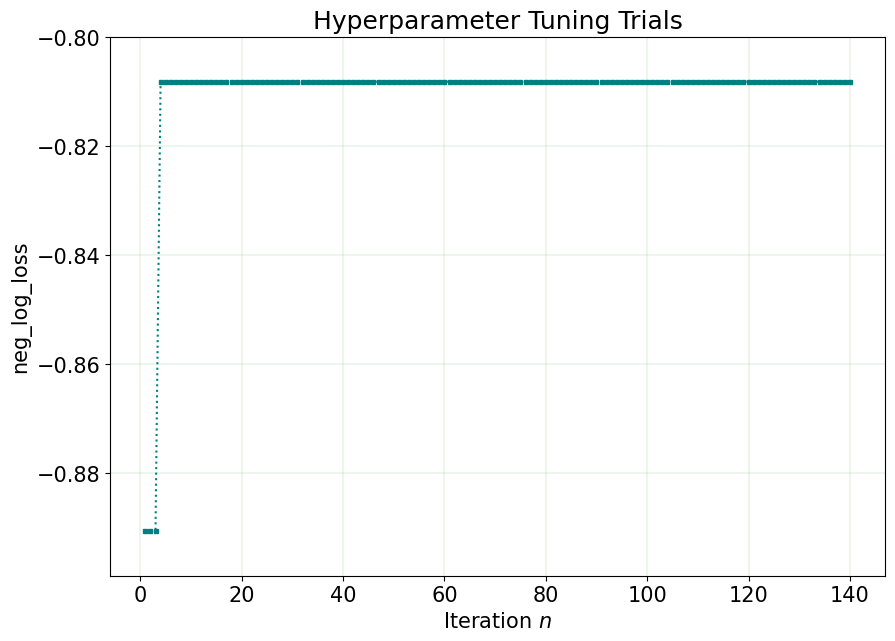

In [14]:
# Each trial is a row in a dataframe that contains
# Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
trials = est1.completed_trials_summary_[est1.completed_trials_summary_["Step"].str.contains('Model Tuning')]
trials.replace([np.inf, -np.inf], np.nan, inplace=True)
trials.dropna(subset=[name_of_score_column], inplace = True)
trials.drop(trials[trials['Finished'] == -1].index, inplace = True)
trials['Finished']= trials['Finished'].apply(lambda x: time.mktime(datetime.datetime.strptime(x,
                                             "%a %b %d %H:%M:%S %Y").timetuple()))
trials.sort_values(by=['Finished'],ascending=True, inplace = True)
scores = trials[name_of_score_column].tolist()
score = []
score.append(scores[0])
for i in range(1,len(scores)):
    if scores[i]>= score[i-1]:
        score.append(scores[i])
    else:
        score.append(score[i-1])
y_margin = 0.10 * (max(score) - min(score))

fig, ax = plt.subplots(1)
ax.set_title("Hyperparameter Tuning Trials")
ax.set_xlabel("Iteration $n$")
ax.set_ylabel(est1._inferred_score_metric[0].name)
ax.grid(color='g', linestyle='-', linewidth=0.1)
ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
ax.plot(range(1, len(trials) + 1), score, 'k:', marker="s", color='teal', markersize=3)
plt.show()

<a id='advanced'></a>
### Advanced AutoML Configuration

You can also configure the pipeline with suitable parameters according to your needs.

In [15]:
custom_pipeline = automlx.Pipeline(
    task='classification',
    model_list=[                 # Specify the models you want the AutoML to consider
        'GaussianNB',
        'LGBMClassifier',
],
    min_features=1.0,            # Specify minimum features to force the model to use. It can take 3 possible types of values:
                                 # If int, 0 < min_features <= n_features,
                                 # If float, 0 < min_features <= 1.0, 1.0 means disabling feature selection
                                 # If list, names of features to keep, for example ['a', 'b'] means keep features 'a' and 'b'

    n_algos_tuned=2,             # Choose how many models to tune
    adaptive_sampling=False,     # Disable or enable Adaptive Sampling step. Default to `True`
    preprocessing=True,          # Disable or enable Preprocessing step. Default to `True`
    search_space={},             # You can specify the hyper-parameters and ranges AutoML searches
    max_tuning_trials=2,         # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric='f1_macro',     # Any scikit-learn metric or a custom function
)

A few of the advanced settings can be passed directly to the pipeline's fit method, instead of its constructor.

In [16]:
custom_pipeline.fit(
    X_train,
    y_train,
    X_valid,
    y_valid,
    col_types=["text"],
    time_budget= 50,    # Specify time budget in seconds
    cv='auto'           # Automatically pick a good cross-validation (cv) strategy for the user's dataset.
                        # Ignored if X_valid and y_valid are provided.
                        # Can also be:
                        #   - An integer (for example, to use 5-fold cross validation)
                        #   - A list of data indices to use as splits (for advanced, such as time-based splitting)
)
y_proba = custom_pipeline.predict_proba(X_test)
score_default = f1_score(y_test, y_predict, average="micro")

print(f'Score on test data : {score_default}')

[2024-05-23 10:42:32,537] [automlx.interface] Dataset shape: (3394,1)
[2024-05-23 10:42:32,598] [automlx.interface] Model Tune disabled.
[2024-05-23 10:42:32,885] [automlx.data_transform] Running preprocessing. Number of features: 2
[2024-05-23 10:42:52,004] [automlx.data_transform] Preprocessing completed. Took 19.119 secs
[2024-05-23 10:42:52,334] [automlx.process] Running Model Generation
[2024-05-23 10:43:10,641] [automlx.process] Model Generation completed.
[2024-05-23 10:43:11,010] [automlx.model_selection] Running Model Selection
[2024-05-23 10:43:11,011] [automlx.trials] Fewer models (2) than top_k (2) provided, skipping model selection
[2024-05-23 10:43:22,393] [automlx.interface] Re-fitting pipeline
[2024-05-23 10:44:20,154] [automlx.interface] AutoMLx completed.
Score on test data : 0.6987519915029209


<a id='MLX'></a>
## Machine Learning Explainability

For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the MLExplainer object, which allows to compute a variety of model explanations

<a id='MLX-initializing'></a>
### Initializing an MLExplainer

The MLExplainer object takes as argument the trained model, the training data and labels, as well as the task.

In [17]:
explainer = automlx.MLExplainer(est1,
                              X_train,
                              y_train,
                              target_names=target_names,
                              task="classification",
                              col_types=["text"])

<a id='MLX-global'></a>
### Model Explanations (Global Token Importance)

For text classification tasks, since we first extract tokens (features), the Oracle AutoMLx solution offers a single way to compute a notion of token importance: Global Token Importance. The notion of Global Token Importance intuitively measures how much a token impacts the model's predictions (relative to the provided train labels). Tokens are the most fine-grained building blocks of the NLP model, such as sentences, words, or characters.

#### Computing the importance

We use a permutation-based method to successively measure the importance of each token (feature). Such a method therefore runs in linear time with respect to the
number of features (tokens) in the dataset.

The method `explain_model()` allows to compute such feature importances.

In [18]:
result_explain_model_default = explainer.explain_model()

#### Visualization

There are two options to show the explanation's results:
- `to_dataframe()` will return a dataframe of the results.
- `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance.

In [19]:
result_explain_model_default.to_dataframe(n_tokens=20)

token  attribution  upper_bound  lower_bound
0      israeli     0.014393     0.014393     0.014393
1      atheism     0.012633     0.012633     0.012633
2       hockey     0.012515     0.012515     0.012515
3         bike     0.011961     0.011961     0.011961
4         sale     0.010798     0.010800     0.010797
5     baseball     0.010190     0.010190     0.010190
6         cars     0.010052     0.010055     0.010050
7         moon     0.009464     0.009464     0.009464
8     atheists     0.009376     0.009376     0.009376
9     graphics     0.008399     0.008466     0.008332
10     windows     0.007966     0.007966     0.007966
11  encryption     0.006958     0.006958     0.006958
12    pitching     0.005990     0.005990     0.005990
13        guns     0.005813     0.005813     0.005813
14      israel     0.005534     0.005534     0.005534
15     playoff     0.004587     0.004587     0.004587
16  christians     0.004034     0.004034     0.004034
17       orbit     0.003647     0.003647     0.003647
18     clipper     0.003382     0.003382     0.003382
19       space     0.003147     0.003147     0.003147

In [20]:
result_explain_model_default.show_in_notebook(n_tokens=20)

<a id='MLX-local'></a>
## Local Token importance

For text classification tasks, since we first extract tokens (features), the Oracle AutoMLx solution offers a single way to compute a notion of token importance: Local Token Importance. The notion of Local Token Importance intuitively measures how much a token impacts an instance's predictions.

#### Compute the importance

By default we use a surrogate method to successively measure the importance of each token in a given instance. Such a method therefore runs in linear time with respect to the number of features in the dataset.

The method `explain_prediction()` allows to compute such feature importances.

In [21]:
index = 0
X_train.reset_index(drop=True, inplace=True)
result_explain_prediction_default = explainer.explain_prediction(X_train.iloc[index:index + 1])

There are two options to show the explanation's results:
 - `to_dataframe()` will return a dataframe of the results.
 - `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance.

#### Visualization

In [22]:
result_explain_prediction_default[0].to_dataframe()

Attribution       Token                 Target
0    9.653031e-01     Turkish  talk.politics.mideast
1    1.108578e-02       Argic  talk.politics.mideast
2   -5.332916e-03       Turks  talk.politics.mideast
3   -1.512145e-03         000  talk.politics.mideast
4   -1.293691e-03      killed  talk.politics.mideast
..            ...         ...                    ...
109  8.963141e-15  Sarikamish  talk.politics.mideast
110 -7.590106e-15     eastern  talk.politics.mideast
111 -1.061330e-16         600  talk.politics.mideast
112 -3.483082e-17          26  talk.politics.mideast
113 -1.813207e-17    thousand  talk.politics.mideast

[114 rows x 3 columns]

In [23]:
result_explain_prediction_default[0].show_in_notebook()

<a id='ref'></a>
## References
* Oracle AutoML http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* Interpretable Machine Learning https://christophm.github.io/interpretable-ml-book/
* LIME https://arxiv.org/pdf/1602.04938
* 20newsgroup http://qwone.com/~jason/20Newsgroups/